In [24]:
import pandas as pd

import seaborn as sns

sns.set_context("talk")
import matplotlib.pyplot as plt
import statsmodels

import statsmodels.formula.api as smf
import numpy as np

plt.style.use("ggplot")

In [25]:
data=pd.read_csv('clean_data/final_dataset.csv')
data[['income_census','pop_census']]=np.log(data[['income_census','pop_census']])

In [26]:
data.columns
y = "mortality_drug_us"
x = [
    "pop_census",
    "nhwrate",
    "blkrate",
    "asianrate",
    "hisprate",
    "nativerate",
    "state_mormon",
    "altitude",
    "mormon",
    "income_census"
]

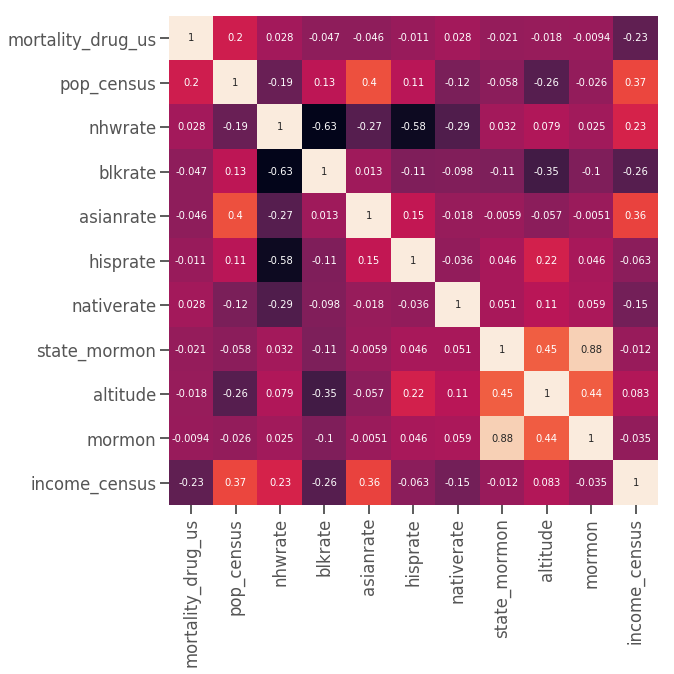

In [27]:
plt.figure(figsize=(9,9))
sns.heatmap(data[[y]+x].corr(),annot=True,square=True,cbar=False)

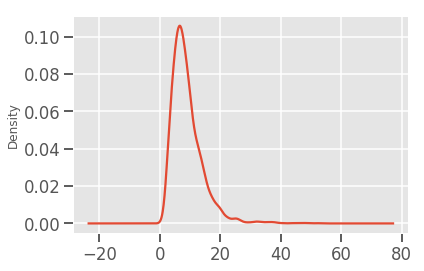

In [28]:
#lognormal
data[y].plot.kde()

In [29]:
data[y].describe()

count    3126.000000
mean        9.078948
std         5.211653
min         1.680000
25%         5.650000
50%         7.930000
75%        11.220000
max        52.010000
Name: mortality_drug_us, dtype: float64

In [30]:
import statsmodels.api as sm


def regress(
    x,
    y,
    model="ols",
    plot=False,
    summary=False,
    show_nonsignificant=False,
    data=data,
    log=False,
):
    # Weighted regression due to different pop size in each county. Lower pops will be noisier.
    if log:
        expr = f"np.log({y})~" + "+".join(x)
        logiflog = np.log
    else:
        expr = f"({y})~" + "+".join(x)
        logiflog = lambda x: x
    if model == "glm":
        ret = smf.glm(
            expr,
            data=data,
            family=sm.families.Gaussian(link=sm.families.links.log()),
            var_weights=data.pop_census,
        ).fit()
    elif model == "wls":
        ret = smf.ols(expr, data=data).fit()
    else:
        ret = smf.wls(expr, data=data, weights=data["pop_census"]).fit()
    if summary:
        display(ret.summary())
    if plot:
        if model == "glm":
            pred = logiflog(ret.predict(data[x]).squeeze())
        else:
            pred = logiflog(ret.predict(data[x]).squeeze())
        display(plt.scatter(data[y], pred))
        max_y = max(data[y])
        min_y = min(data[y])
        plt.plot([min_y, max_y], [min_y, max_y], c="blue")
    df = pd.concat([ret.params, ret.pvalues], axis=1)

    df.columns = ["coefficients", "pvalue"]
    df["pvalue"] = df["pvalue"].round(3)
    df["pvalue"] = np.where(
        df.pvalue < 0.05, df.pvalue.astype(str) + "*", df.pvalue.astype(str)
    )
    if not show_nonsignificant:
        df = df[df.pvalue.str.contains("\*")]

    mean_frame = data[x].mean().to_frame().T
    if 'state' in x:
        mean_frame['state']='Utah'
    mean_predicted = ret.predict(mean_frame).values
    display(f"Baseline value: {np.round(mean_predicted,2).squeeze()}")

    for var in df.index:
        if var != "Intercept" and "state[" not in var:
            df.loc[var, "var_max_value"] = data[var].max()
            df.loc[var, "var_mean_value"] = data[var].mean()
            df.loc[var, "effect_mean_to_max"] = (
                ret.predict(mean_frame.assign(**{var: data[var].max()})).values
                - mean_predicted
            )
    # df["effect_pc"] = 100 * (df.effect_mean_to_max) / mean_predicted
    df = df.round(3)

    return df, ret


t, mod = regress(x, y, model="glm", log=False)
t

'Baseline value: 8.55'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,18.053,0.0*,NaN,NaN,NaN
pop_census,0.224,0.0*,16.078,10.225,23.246
nhwrate,-2.585,0.0*,1.000,0.788,-3.604
blkrate,-3.572,0.0*,0.861,0.089,-8.012
asianrate,-5.851,0.0*,0.522,0.011,-8.124
hisprate,-3.567,0.0*,0.983,0.078,-8.215
nativerate,-3.391,0.0*,0.889,0.017,-8.109
altitude,0.000,0.0*,4008.285,424.280,8.530
mormon,-0.001,0.0*,1007.860,21.801,-4.889
income_census,-1.551,0.0*,11.073,9.996,-6.944


In [31]:
# #Keep state as per BIC and AIC
# df,mod=regress(x,y2,model='glm')
# df
# #???? (weird numerical error)

In [32]:
df,mod=regress(x,y,model='ols',)
df

'Baseline value: 9.08'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,131.600,0.0*,NaN,NaN,NaN
pop_census,1.672,0.0*,16.078,10.225,9.788
nhwrate,-29.789,0.0*,1.000,0.788,-6.304
blkrate,-36.792,0.0*,0.861,0.089,-28.428
asianrate,-45.551,0.0*,0.522,0.011,-23.280
hisprate,-35.362,0.0*,0.983,0.078,-32.008
nativerate,-33.569,0.0*,0.889,0.017,-29.262
altitude,0.001,0.0*,4008.285,424.280,5.286
mormon,-0.006,0.008*,1007.860,21.801,-5.576
income_census,-10.957,0.0*,11.073,9.996,-11.801


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_drug_us   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     89.57
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          6.96e-163
Time:                        16:56:04   Log-Likelihood:                -9200.8
No. Observations:                3126   AIC:                         1.842e+04
Df Residuals:                    3115   BIC:                         1.849e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       133.9548      6.519     20.547      0.000     121.172     146.738
pop_census        1.6500      0.070     23.467      0.000       1.512       1.788
nhwrate         -32.3902      4.997     -6.482      0.000     -42.187     -22.593
blkrate         -39.4191      4.973     -7.927      0.000     -49.169     -29.669
asianrate       -47.6390      7.294     -6.531      0.000     -61.940     -33.338
hisprate        -37.5963      4.987     -7.539      0.000     -47.375     -27.818
nativerate      -36.2970      5.485     -6.618      0.000     -47.051     -25.543
state_mormon     -0.3716      2.431     -0.153      0.879      -5.137       4.394
altitude          0.0015      0.000      6.831      0.000       0.001       0.002
mormon           -0.0052      0.002     -2.552      0.011      -0.009      -0.001
income_census   -10.9178      0.466    -23.422      0.000     -11.832     -10.004
==============================================================================
Omnibus:                     1461.732   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12488.424
Skew:                           2.027   Prob(JB):                         0.00
Kurtosis:                      11.913   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 9.08'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,133.955,0.0*,NaN,NaN,NaN
pop_census,1.650,0.0*,16.078,10.225,9.657
nhwrate,-32.390,0.0*,1.000,0.788,-6.855
blkrate,-39.419,0.0*,0.861,0.089,-30.458
asianrate,-47.639,0.0*,0.522,0.011,-24.347
hisprate,-37.596,0.0*,0.983,0.078,-34.030
nativerate,-36.297,0.0*,0.889,0.017,-31.640
altitude,0.001,0.0*,4008.285,424.280,5.280
mormon,-0.005,0.011*,1007.860,21.801,-5.170
income_census,-10.918,0.0*,11.073,9.996,-11.758


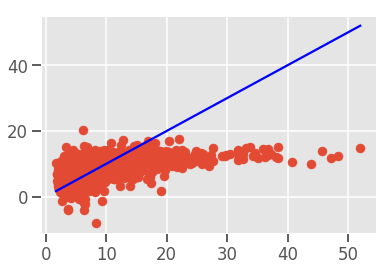

In [33]:
#Not much difference from plain OLS
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

In [34]:
target = data.query('county=="Salt Lake"')[x]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0] - mod.predict(target).values[0],
    }
)

predicted               11.998342
baseline                 9.980000
no_mormons              15.108598
no_mormons-predicted     3.110256
dtype: float64

# Effect of mormon

But what if? Mormon->Income?

'Baseline value: 10.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,9.767,0.0*,NaN,NaN,NaN
mormon,-0.000,0.002*,1007.860,21.801,-0.127
nhwrate,0.275,0.0*,1.000,0.788,0.058
blkrate,-0.168,0.0*,0.861,0.089,-0.130
asianrate,3.753,0.0*,0.522,0.011,1.918
nativerate,-0.278,0.0*,0.889,0.017,-0.242


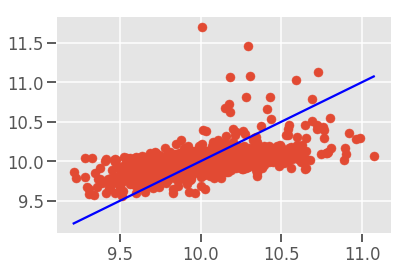

In [35]:
df, mod = regress(
    ["mormon", "nhwrate", "blkrate", "asianrate", "nativerate"],
    "income_census",
    plot=True,
)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_drug_us   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     89.57
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          6.96e-163
Time:                        16:56:05   Log-Likelihood:                -9200.8
No. Observations:                3126   AIC:                         1.842e+04
Df Residuals:                    3115   BIC:                         1.849e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       133.9548      6.519     20.547      0.000     121.172     146.738
pop_census        1.6500      0.070     23.467      0.000       1.512       1.788
nhwrate         -32.3902      4.997     -6.482      0.000     -42.187     -22.593
blkrate         -39.4191      4.973     -7.927      0.000     -49.169     -29.669
asianrate       -47.6390      7.294     -6.531      0.000     -61.940     -33.338
hisprate        -37.5963      4.987     -7.539      0.000     -47.375     -27.818
nativerate      -36.2970      5.485     -6.618      0.000     -47.051     -25.543
state_mormon     -0.3716      2.431     -0.153      0.879      -5.137       4.394
altitude          0.0015      0.000      6.831      0.000       0.001       0.002
mormon           -0.0052      0.002     -2.552      0.011      -0.009      -0.001
income_census   -10.9178      0.466    -23.422      0.000     -11.832     -10.004
==============================================================================
Omnibus:                     1461.732   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12488.424
Skew:                           2.027   Prob(JB):                         0.00
Kurtosis:                      11.913   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 9.08'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,133.955,0.0*,NaN,NaN,NaN
pop_census,1.650,0.0*,16.078,10.225,9.657
nhwrate,-32.390,0.0*,1.000,0.788,-6.855
blkrate,-39.419,0.0*,0.861,0.089,-30.458
asianrate,-47.639,0.0*,0.522,0.011,-24.347
hisprate,-37.596,0.0*,0.983,0.078,-34.030
nativerate,-36.297,0.0*,0.889,0.017,-31.640
altitude,0.001,0.0*,4008.285,424.280,5.280
mormon,-0.005,0.011*,1007.860,21.801,-5.170
income_census,-10.918,0.0*,11.073,9.996,-11.758


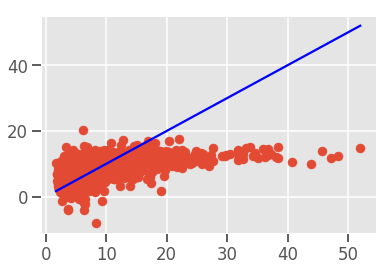

In [36]:
x2=x+['state']
#Keep state as per BIC and AIC
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_drug_us   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     52.50
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:56:05   Log-Likelihood:                -8504.4
No. Observations:                3126   AIC:                         1.713e+04
Df Residuals:                    3066   BIC:                         1.749e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       100.0984      7.348     13.622      0.000      85.691     114.506
state[T.Alaska]                   1.6205      1.070      1.515      0.130      -0.477       3.718
state[T.Arizona]                  1.2723      1.121      1.135      0.256      -0.926       3.470
state[T.Arkansas]                -2.6415      0.631     -4.189      0.000      -3.878      -1.405
state[T.California]               2.8426      0.744      3.821      0.000       1.384       4.301
state[T.Colorado]                -2.2009      0.837     -2.629      0.009      -3.843      -0.559
state[T.Connecticut]              0.6100      1.411      0.432      0.666      -2.157       3.377
state[T.Delaware]                 2.9529      2.195      1.345      0.179      -1.352       7.258
state[T.District of Columbia]    11.1273      3.758      2.961      0.003       3.759      18.496
state[T.Florida]                  2.5890      0.656      3.948      0.000       1.303       3.875
state[T.Georgia]                  1.4644      0.542      2.703      0.007       0.402       2.527
state[T.Hawaii]                  -7.3110      2.746     -2.663      0.008     -12.695      -1.927
state[T.Idaho]                   -3.3975      0.771     -4.406      0.000      -4.909      -1.886
state[T.Illinois]                -1.9681      0.609     -3.232      0.001      -3.162      -0.774
state[T.Indiana]                 -0.6004      0.626     -0.959      0.337      -1.827       0.627
state[T.Iowa]                    -5.2295      0.618     -8.458      0.000      -6.442      -4.017
state[T.Kansas]                  -2.7261      0.619     -4.405      0.000      -3.940      -1.513
state[T.Kentucky]                 6.2528      0.593     10.551      0.000       5.091       7.415
state[T.Louisiana]                1.8334      0.650      2.819      0.005       0.558       3.109
state[T.Maine]                   -2.3049      1.050     -2.194      0.028      -4.365      -0.245
state[T.Maryland]                -2.4774      0.900     -2.751      0.006      -4.243      -0.712
state[T.Massachusetts]            1.0447      1.118      0.934      0.350      -1.148       3.237
state[T.Michigan]                -1.4777      0.634     -2.332      0.020      -2.720      -0.235
state[T.Minnesota]               -4.8412      0.635     -7.621      0.000      -6.087      -3.596
state[T.Mississippi]              0.1892      0.619      0.306      0.760      -1.024       1.402
state[T.Missouri]                -1.2289      0.596     -2.064      0.039      -2.397      -0.061
state[T.Montana]                 -3.1909      0.728     -4.383      0.000      -4.618      -1.764
state[T.Nebraska]                -5.2064      0.637     -8.170      0.000      -6.456      -3.957
state[T.Nevada]                   3.0635     

'Baseline value: 9.14'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,100.098,0.0*,NaN,NaN,NaN
state[T.Arkansas],-2.641,0.0*,NaN,NaN,NaN
state[T.California],2.843,0.0*,NaN,NaN,NaN
state[T.Colorado],-2.201,0.009*,NaN,NaN,NaN
state[T.District of Columbia],11.127,0.003*,NaN,NaN,NaN
state[T.Florida],2.589,0.0*,NaN,NaN,NaN
state[T.Georgia],1.464,0.007*,NaN,NaN,NaN
state[T.Hawaii],-7.311,0.008*,NaN,NaN,NaN
state[T.Idaho],-3.397,0.0*,NaN,NaN,NaN
state[T.Illinois],-1.968,0.001*,NaN,NaN,NaN


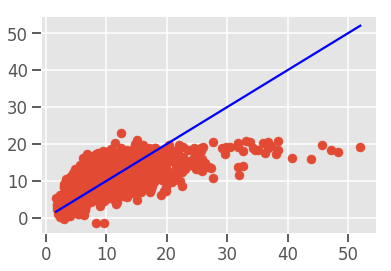

In [37]:
df,mod=regress(x2,y,model='wls',plot=True,summary=True)
df

In [38]:
target = data.query('county=="Salt Lake"')[x2]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0] - mod.predict(target).values[0],
    }
)

predicted               11.102881
baseline                 9.980000
no_mormons              13.727775
no_mormons-predicted     2.624894
dtype: float64

Final prediction from linear models: Full ->0 demormonisation would lead to a rise in the drug use mortality rate of 2.63 pp.

# Let's try catboost

In [39]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMRegressor,Dataset
from lightgbm import plot_importance

ITERATIONS=100
def get_bayes_tuner(cat_feat=[]):
    search_space = {
 
        "num_leaves":(10,40),
        "min_child_samples":(5,50),
        "learning_rate":(0.01,0.5,"uniform"),
        "n_estimators":(10,500),
        "min_split_gain":(0.,1.,"uniform"),
        "colsample_bytree":(0.5,0.8,1)

    }
    return BayesSearchCV(
        estimator=LGBMRegressor(n_jobs=6),
        search_spaces=search_space,
        cv=KFold(n_splits=20, shuffle=True, random_state=42),
        n_jobs=2,
        n_iter=ITERATIONS,
        verbose=3,
        refit=True,
        random_state=42,
        scoring="r2",
        fit_params={'categorical_feature':cat_feat}
    )

In [40]:
data['state_factor'],factor_array=pd.factorize(data.state)

In [41]:
x3=x2[::1]
x3.remove('state')
x3.append('state_factor')
x3.append('income_census')

In [42]:
cat_pos = np.where(data[x3].dtypes == int)[0].tolist()

bayes_tuner = get_bayes_tuner(cat_pos)
cat = bayes_tuner.fit(data[x3], data[y])

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   49.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   31.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   22.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   28.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   32.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   38.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   21.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  3.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   35.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   25.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.5min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   33.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.9min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   21.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   36.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   23.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.6min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.3min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.6min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   27.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.7min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   10.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.1s finished


In [43]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
88,0.474422,0.560147,0.638219,0.692309,0.601550,0.501608,0.673652,0.697963,0.476587,0.608574,...,0.006647,0.004668,0.000480,0.8,0.041951,5,0.000000,267,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
67,0.475483,0.549490,0.649344,0.715490,0.608520,0.485471,0.664032,0.690266,0.450457,0.611752,...,0.035653,0.005770,0.001279,0.8,0.021601,5,0.563330,439,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
87,0.480374,0.548465,0.653078,0.708864,0.604101,0.487178,0.675322,0.674411,0.448800,0.589389,...,0.027300,0.004641,0.000368,0.8,0.047407,5,0.000000,264,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
58,0.471664,0.548155,0.653647,0.712742,0.619340,0.480512,0.650576,0.720450,0.403335,0.606791,...,0.008480,0.005561,0.000456,0.8,0.039683,50,0.387366,413,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
96,0.477570,0.542985,0.658507,0.708629,0.605709,0.487291,0.617708,0.708097,0.407489,0.597473,...,0.098027,0.005154,0.002113,0.8,0.031825,50,0.899815,287,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
79,0.474872,0.570284,0.642433,0.688331,0.608383,0.489202,0.678883,0.684605,0.502346,0.614650,...,0.006728,0.004847,0.000280,0.8,0.042180,5,0.000000,402,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
72,0.458215,0.553380,0.647642,0.696398,0.609233,0.462538,0.681384,0.679953,0.476456,0.608770,...,0.006230,0.004572,0.000721,0.8,0.050250,5,1.000000,418,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
89,0.459608,0.566608,0.660821,0.721917,0.615835,0.481073,0.628312,0.702222,0.411279,0.597702,...,0.011579,0.005006,0.000261,0.8,0.037635,50,0.000000,266,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
28,0.473220,0.541116,0.645609,0.695002,0.600166,0.499062,0.677795,0.706761,0.421304,0.612990,...,8.081729,0.031945,0.020159,1.0,0.033872,33,0.373043,406,39,"{'colsample_bytree': 1, 'learning_rate': 0.033..."
75,0.469566,0.553860,0.646647,0.698467,0.605673,0.539627,0.671114,0.672904,0.463281,0.589896,...,0.006503,0.004677,0.000306,0.8,0.054071,5,1.000000,441,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


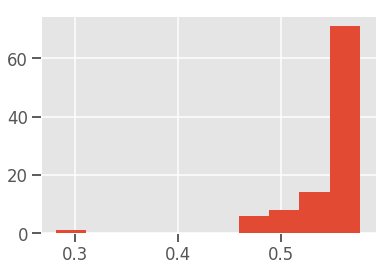

In [44]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score').mean_test_score.hist()

Catboost is a nonlinear model, so we lose explainability. Feature importances in tree models are commonly used to try to interpret them, but those may be biased by multicollinearity. Let's try to see what we get from them first:

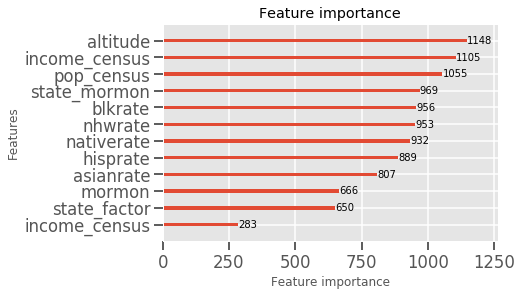

In [45]:
plot_importance(cat.best_estimator_)

Again, mormon comes as relatively not important

### Explanation with SHAP

These feature importances may be fake news because of multicollinearity issues, so we turn to SHAP to see what features drive this model.

[SHAP](https://arxiv.org/pdf/1705.07874.pdf) produces a score for each pair of (feature,sample), indicating how much that feature contributed in that particular case. In effect SHAP is solving a credit assignment problem.

Unlike with the coefficients in OLS, here we have scores per pair of features, which make it more important to visualise what is going on on a case by case basis to see if trends emerge

In [46]:
import shap
shap.initjs()


In [47]:
explainer=shap.TreeExplainer(cat.best_estimator_)
shaps=explainer.shap_values(data[x３])

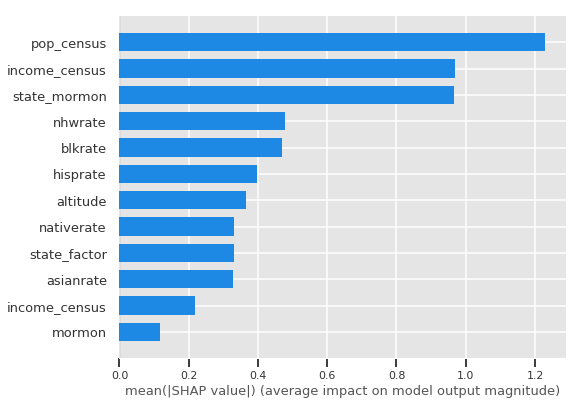

In [48]:
shap.summary_plot(shaps,data[x3], plot_type="bar")

Also in CatBoost, mormons are not a significant variable

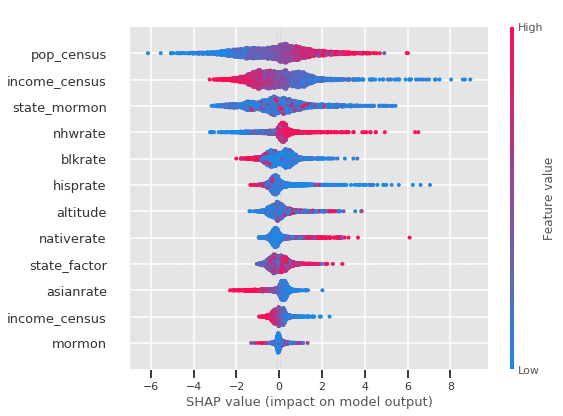

In [49]:
# This plot measures the impact of a variable on poverty. Each point is a particular county.
# The y-size of each row represents the density of points at that particular point
# High SHAP values mean in that case the variable in that case contributed to a higher poverty rate
# The sense in which it contributed can be glanced from the colorbar
# For example, the blue points in income_census mean that when income was low, the SHAP value was high (higher poverty)
# Positive values mean that in that part
shap.summary_plot(shaps,data[x3])

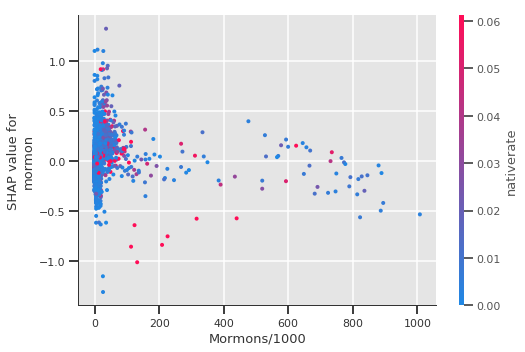

In [75]:
ax=shap.dependence_plot("mormon", shaps, data[x3],
                     interaction_index="nativerate",show=False)
plt.xlabel('Mormons/1000')
plt.tight_layout()
plt.savefig('figures/alcohol_shap.png')

In [71]:
shap.dependence_plot?

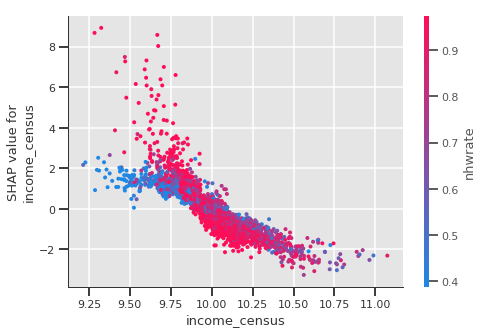

In [51]:
shap.dependence_plot("income_census", shaps,data[x3])

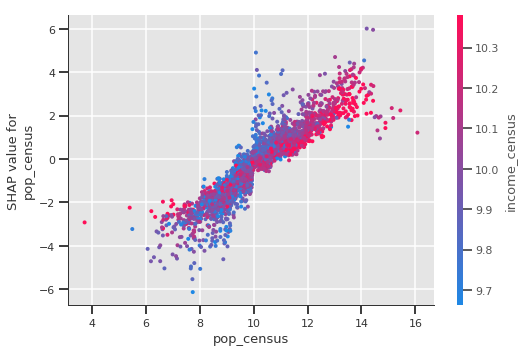

In [79]:
shap.dependence_plot("pop_census", shaps,data[x3],show=False)
plt.tight_layout()
plt.savefig('figures/alcohol_pop.png')

In [52]:
#Salt Lake
shap.force_plot(explainer.expected_value,shaps[2778,:],data[x3].loc[2778,:])

In [53]:
shap.force_plot(explainer.expected_value,shaps[217,:],data[x3].loc[217,:])

In [54]:
data.query('county=="San Francisco"')

,state,county,povrate,pop_census,income_census,nhwrate,blkrate,asianrate,nativerate,hisprate,...,pov_saipe_2017,mortality_alcohol,mortality_drug_us,mortality_self_ha,mortality_interpe,mortality,outcomes,state_mormon,altitude,state_factor
217,California,San Francisco,0.118615,13.567917,10.724984,0.420773,0.060655,0.333613,0.002651,0.147085,...,0.101,7.41,19.12,12.43,6.54,0.234244,0.228563,0.020478,15.562419,4


In [55]:
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     10.707930
baseline       9.980000
no_mormons    10.386059
diff          -0.321871
dtype: float64

With catboost the effect is reversed: Demormonisation would reduce drug-related deaths by 0.32 pp. But there is some difference between the baseline (real) and predicted values.

In [56]:
#The effect is also there for more mormons
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=1000)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     10.707930
baseline       9.980000
no_mormons    10.209027
diff          -0.498903
dtype: float64

What would happen if SLC had a substantial native population?

In [57]:
target = data.query('county=="Salt Lake"')[x3]
counterfactual = target.assign(nhwrate=0,hisprate=0,blkrate=0,nativerate=1,asianrate=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "counterf": cat.predict(counterfactual)[0],
         "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
    }
)

predicted    10.707930
baseline      9.980000
counterf     11.640951
diff          0.933021
dtype: float64

In that case alcoholism would increase by a bit more.